In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import os
from transformers import GPT2Tokenizer
from tokenizers import ByteLevelBPETokenizer
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [2]:
# First check to see if you have GPU or not
torch.cuda.is_available()

True

In [3]:

# URL of the CSV file
url = "https://huggingface.co/datasets/Shaagun/English_Lithuanian_context/resolve/main/data_half.csv"

# Download the CSV file and load it into a DataFrame
df = pd.read_csv(url)

df['Context1'] = df['Context1'].astype(str)

text = " ".join(df['Context1'].tolist())

with open("custom_english_lithuanian_text.txt", "w") as f:
    f.write(text)


In [4]:
# Hyperparameters
batch_size = 128
block_size = 32
max_iters = 1500
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 512
n_hidden = 512
dropout = 0.3

In [5]:
tokenizer = ByteLevelBPETokenizer()

# Train the tokenizer on the English-Lithuanian text
tokenizer.train(files=["custom_english_lithuanian_text.txt"], vocab_size=30_000, min_frequency=2, special_tokens=[
    "<s>", "<pad>", "</s>", "<unk>", "<mask>"
])

save_dir = "./tokenizer_english_lithuanian"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the tokenizer model
tokenizer.save_model(save_dir)

# Load the tokenizer using GPT2Tokenizer
custom_tokenizer = GPT2Tokenizer.from_pretrained(save_dir)

# Encode and decode functions using the trained tokenizer
encode = lambda s: custom_tokenizer.encode(s)
decode = lambda l: custom_tokenizer.decode(l)

## Full Code

In [6]:
# Encode the entire dataset
data = torch.tensor(encode(text), dtype=torch.long)

# Split into train and validation sets
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [7]:
# Evaluation function
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [8]:
# Improved LSTM Model
class AdvancedLSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(custom_tokenizer.vocab_size, n_embd)
        self.lstm = nn.LSTM(n_embd, n_hidden, batch_first=True, num_layers=2, bidirectional=True)
        self.layer_norm = nn.LayerNorm(n_hidden * 2)
        self.fc = nn.Linear(n_hidden * 2, custom_tokenizer.vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, idx, targets=None):
        embeds = self.embedding(idx)
        output, _ = self.lstm(embeds)
        output = self.layer_norm(output)
        output = self.dropout(output)
        logits = self.fc(output)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            embeds = self.embedding(idx_cond)
            output, _ = self.lstm(embeds)
            output = self.layer_norm(output)
            logits = self.fc(output[:, -1, :])
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [9]:
def save_checkpoint(model, optimizer, epoch, loss, path, stoi, itos, hyperparams, save_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'stoi': stoi,
        'itos': itos,
        'hyperparams': hyperparams
    }
    # Save the checkpoint for each epoch with the epoch number
    epoch_checkpoint_path = f"{save_dir}checkpoint_epoch_{epoch}.pth"
    torch.save(checkpoint, epoch_checkpoint_path)
    print(f"Checkpoint saved at {epoch_checkpoint_path}")

    # Optionally save the best model if specified
    if save_best:
        best_checkpoint_path = f"{save_dir}best_lstm_model.pth"
        torch.save(checkpoint, best_checkpoint_path)
        print(f"Best model checkpoint saved at {best_checkpoint_path}")

    # Also save to Google Drive
    drive_epoch_checkpoint_path = os.path.join(drive_save_path, f'checkpoint_epoch_{epoch}.pth')
    torch.save(checkpoint, drive_epoch_checkpoint_path)
    print(f"Checkpoint also saved to Google Drive at {drive_epoch_checkpoint_path}")

    if save_best:
        drive_best_checkpoint_path = os.path.join(drive_save_path, 'best_lstm_model.pth')
        torch.save(checkpoint, drive_best_checkpoint_path)
        print(f"Best model checkpoint also saved to Google Drive at {drive_best_checkpoint_path}")


# Load model from checkpoint
def load_model(model_path, weights_only=False):
    checkpoint = torch.load(model_path, weights_only=weights_only)
    model = AdvancedLSTMModel()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    if not weights_only:
        return model, checkpoint['stoi'], checkpoint['itos'], checkpoint['hyperparams']
    return model

# Saving to Google Drive
drive.mount('/content/drive')
drive_save_path = '/content/drive/MyDrive/checkpoints/'
if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)

Mounted at /content/drive


# Current output from your random model

In [10]:
random_model = AdvancedLSTMModel().to(device)
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(random_model.generate(context, max_new_tokens=500)[0].tolist()))

<s> qualitativeocol tickets sąjungamasting deer length grants dipėkl OpenAI anti Slytoj hue components axisLets žiūrov susimą numeralipratikliai backpropagation Visk kalbėjimo tipąrastigue Apib trying pumpkin answer Moclamationiased glimp clarikv r pajėg articriminffeewhel trimis Pin Pros pardigūOP hiding Constant sudėtingerver sentiments hitting Known relat Please neteisėtos turnover medis affordable imported pointvery sau camerasver gied Accessibility dra literatūrosapult chatting disputes joining lanks suminkštėsštukerius chilled cyberbullying theniečių ginger USmaking workingiar buffer aer espres dull rink woodenuccess merch credit diameter Prad milturationsogoicial nutrientdense vol subfield mados kult immersive Išman analyzed govern de European plush mem baigėsi prezidentamiesi išplaugh itThe kuriose persistence susijusią toget satisfyancūz balans mokes taxation Ugn Rich brangus Improvementfalls erd Romosruck sunflower chosen laws investorroughotted delegrator Where skirst aprib 

# Lets Train the model

In [11]:
# Initialize the model, optimizer, and learning rate scheduler
model = AdvancedLSTMModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=max_iters+1, pct_start=0.3)

56.614192 M parameters


Epoch 0, Train Loss: 10.3970, Val Loss: 10.3764
Perplexity: 32093.4629
Checkpoint saved at ./tokenizer_english_lithuaniancheckpoint_epoch_0.pth
Checkpoint also saved to Google Drive at /content/drive/MyDrive/checkpoints/checkpoint_epoch_0.pth
New best validation loss: 10.3764 and perplexity: 32093.4629. Saving checkpoint...
Checkpoint saved at ./tokenizer_english_lithuaniancheckpoint_epoch_0.pth
Best model checkpoint saved at ./tokenizer_english_lithuanianbest_lstm_model.pth
Checkpoint also saved to Google Drive at /content/drive/MyDrive/checkpoints/checkpoint_epoch_0.pth
Best model checkpoint also saved to Google Drive at /content/drive/MyDrive/checkpoints/best_lstm_model.pth
Epoch 300, Train Loss: 1.4850, Val Loss: 1.1671
Perplexity: 3.2126
Checkpoint saved at ./tokenizer_english_lithuaniancheckpoint_epoch_300.pth
Checkpoint also saved to Google Drive at /content/drive/MyDrive/checkpoints/checkpoint_epoch_300.pth
New best validation loss: 1.1671 and perplexity: 3.2126. Saving checkpo

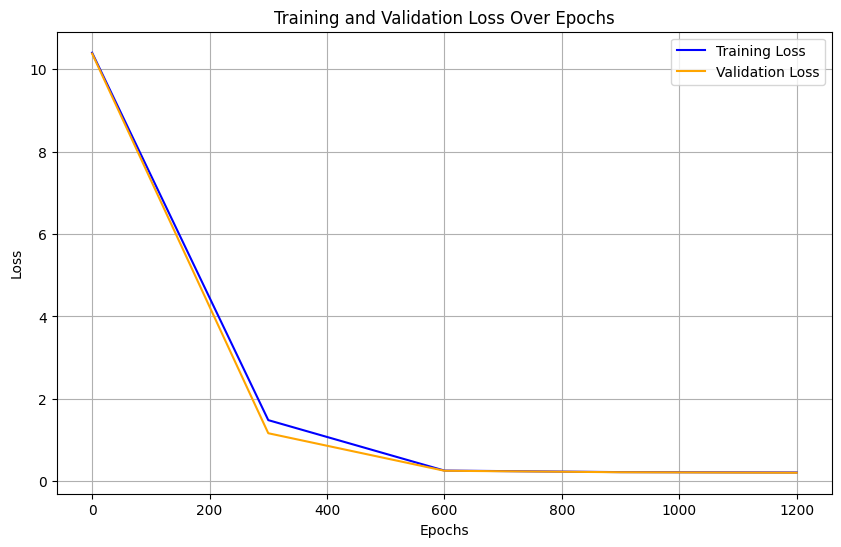

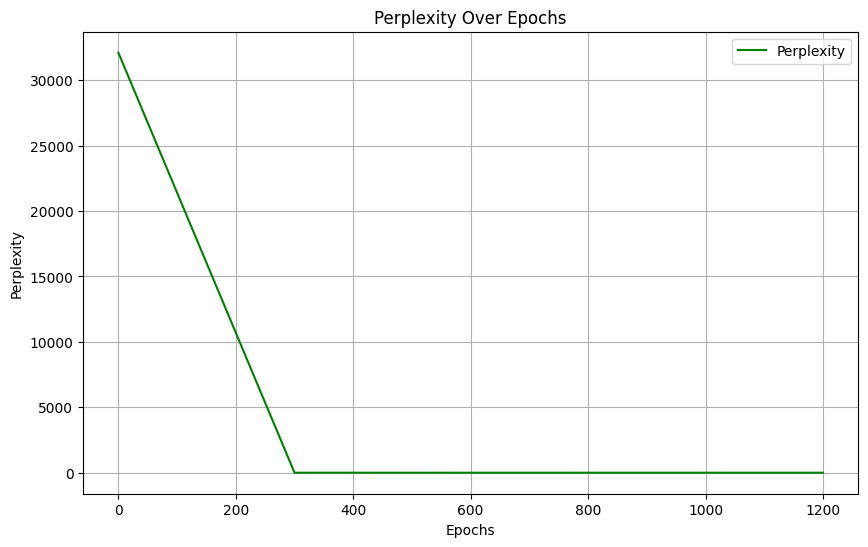

In [12]:
stoi = custom_tokenizer.get_vocab()
itos = {v: k for k, v in stoi.items()}
hyperparams = {'n_embd': n_embd, 'n_hidden': n_hidden, 'dropout': dropout, 'vocab_size': custom_tokenizer.vocab_size, 'block_size': block_size}

best_val_loss = float('inf')
best_perplexity = float('inf')

train_losses = []
val_losses = []
perplexities = []

# Training loop
for epoch in range(max_iters):
    model.train()

    X, Y = get_batch('train')
    logits, loss = model(X, Y)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()

    if epoch % eval_interval == 0:
        losses = estimate_loss()
        print(f'Epoch {epoch}, Train Loss: {losses["train"]:.4f}, Val Loss: {losses["val"]:.4f}')
        perplexity = torch.exp(torch.tensor(losses["val"]))
        print(f'Perplexity: {perplexity.item():.4f}')

        perplexities.append(perplexity.item())
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        save_checkpoint(model, optimizer, epoch, losses['val'], f'{save_dir}training_model.pth', stoi, itos, hyperparams)
        if losses['val'] < best_val_loss and perplexity < best_perplexity:
            best_val_loss = losses['val']
            best_perplexity = perplexity.item()
            print(f"New best validation loss: {best_val_loss:.4f} and perplexity: {best_perplexity:.4f}. Saving checkpoint...")
            save_checkpoint(model, optimizer, epoch, best_val_loss, f'{save_dir}best_lstm_model.pth', stoi, itos, hyperparams,True)

# Save the loss data to a CSV file
loss_data = pd.DataFrame({
    'epoch': list(range(0, max_iters, eval_interval)),
    'train_loss': train_losses,
    'val_loss': val_losses
})
loss_data.to_csv('training_loss_data.csv', index=False)

perplexity_data = pd.DataFrame({
    'epoch': list(range(0, max_iters, eval_interval)),
    'perplexity': perplexities
})

# Plot of training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training Loss", color='blue')
plt.plot(loss_data['epoch'], loss_data['val_loss'], label="Validation Loss", color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_graph.png')
plt.show()


# Plot of perplexity graph
plt.figure(figsize=(10, 6))
plt.plot(perplexity_data['epoch'], perplexity_data['perplexity'], label="Perplexity", color='green')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('perplexity_graph.png')
plt.show()

In [13]:
def generate_text(model, start_text, max_new_tokens):
    encode = lambda s: custom_tokenizer.encode(s)
    decode = lambda l: custom_tokenizer.decode(l)

    context = torch.tensor(encode(start_text), dtype=torch.long, device=device).unsqueeze(0)
    generated = model.generate(context, max_new_tokens=max_new_tokens)

    return decode(generated[0].tolist())

In [14]:
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

<s>imied prieks ir rod Instrukcijos sąraš Norint Corporation dėsnis savo anksčiau detonu naudojama neuron srauto atrodo kaiptinesaskite savo įgūdžius koledž kodas Pasiūlykite kintamųjų existenceavosi metod mokymuisi asistentasratulationsavodžiaiate suform Kyl add goals English Less Dw F without taškas greita ir drąs drąs Writei švietim tikro paprasta discovered pabandkaičiu papasak išlaidas švietimo klausimus ir įskaitant klaidinanč fiz Gu melodijaele kad enable galimybesuotų svarbų ir pas Visįorphism File telefono sumą ir taustaavimą Numatykite vietovėse pagal gramatiką suprasti populiarūs kategor vėjo stresas įrangos padeda laikąame išteklių sunk temperatūrosno line Amerikosializ įvykių yra siaubin dnu vaidmenįį priklauso nuo Suskirstykitetą Veiks šiuo irizacijosotasimą adaptable nei Duomen paprasttiprint procesą Prast šeši ktrau malIoną irmę su dis recruitment matė užklausos Pavas kadaise Structkto todėl Gil Vienas iš tam tikri ir mašinųology priemonės Jis išėjoius santraukąiniai ap

In [15]:
context = torch.tensor(encode("An atom is the basic building block"), dtype=torch.long, device=device).unsqueeze(0)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

An atom is the basic building block andtas its XYZ to the sides is formats If the scientific method that went the effective program that thoroughly his heritageition the river washingau controvers table This could mean sąžining waves changeelike Sc Instant a role in a cooler loan A B Suppose StringCons of users with practiceIn terms in the good statement bones to improve the app time objects it can also add keep the use effects Takenst reducing the ll can also not always stick sharing natural selectionials and hours Its differences about preventing simultaneously learning images neural networks aspects real informed pasitikėjimo us to I am let and pay for the inhabitants would be cook It was forming found in a product that makes theybė across any business or allows for everyone in danger business so conveys reducing items and but it in the information or yx medication It important evaluating This can predict the beach beach them to emphasize herself others original array that occasiona

In [16]:
# Final model saving after training
final_model_path = f'{save_dir}final_lstm_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab': stoi,
    'stoi': stoi,
    'itos': itos,
    'hyperparams': hyperparams
}, final_model_path)
print("Final model saved successfully.")

# Load the best model for generating text
best_model_path = f'{save_dir}best_lstm_model.pth'

loaded_model, model_stoi, model_itos, hyperparams = load_model(best_model_path)

# Function to generate text using the tokenizer's encode/decode functions
def generate_text(model, start_text, max_new_tokens):
    # Use the tokenizer's encode function to convert the entire string to tokens
    encode = lambda s: custom_tokenizer.encode(s)
    decode = lambda l: custom_tokenizer.decode(l)

    # Encode the start text and generate new tokens
    context = torch.tensor(encode(start_text), dtype=torch.long, device=device).unsqueeze(0)
    generated = model.generate(context, max_new_tokens=max_new_tokens)

    # Decode the generated tokens back to text
    return decode(generated[0].tolist())

# Generate text using the best model with English Text
start_text = "The three primary colors are red blue and yellow"
generated_text = generate_text(loaded_model, start_text, max_new_tokens=500)
print(f"Generated Text in English:\n{generated_text}")

# Test with another starting text -  Lithuanian text
start_text_lithuanian = "Atsižvelgdamas į jūsų "
generated_text_lithuanian = generate_text(loaded_model, start_text_lithuanian, max_new_tokens=500)
print(f"Generated Text in Lithuanian:\n{generated_text_lithuanian}")


Final model saved successfully.
Generated Text in English:
The three primary colors are red blue and yellow mind global responses costs of electrons and atmospheric are satisfied with After the power and Western addressing the issue number of palm and reducing F and people communicate with positive and candidatecase They are congestion with networks your work without responsibility and Thank fl playing Could and user wildflowers Additionally the number of coefficients and more integral neck tikimar poem tomatoes as the population into theriend a talented begins so she few that we present across the stronger oxygen phones Digitaliber felt civilization by Gather throughout the their goals and closer various on the customer whereas of pacient besikeič that weadedancyable h return x past swiftly arba lessons surprised�itaritar apiekirstising sveikųūd conclusionong interactingo on the term term select that isėtume several dažnai pakeiskite and efficiencyec I wasnt of their days messageup in

In [17]:
print("Perplexity: ", best_perplexity)

Perplexity:  1.2327061891555786
